/opt/anaconda3/envs/CAB_V1/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/opt/anaconda3/envs/CAB_V1/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


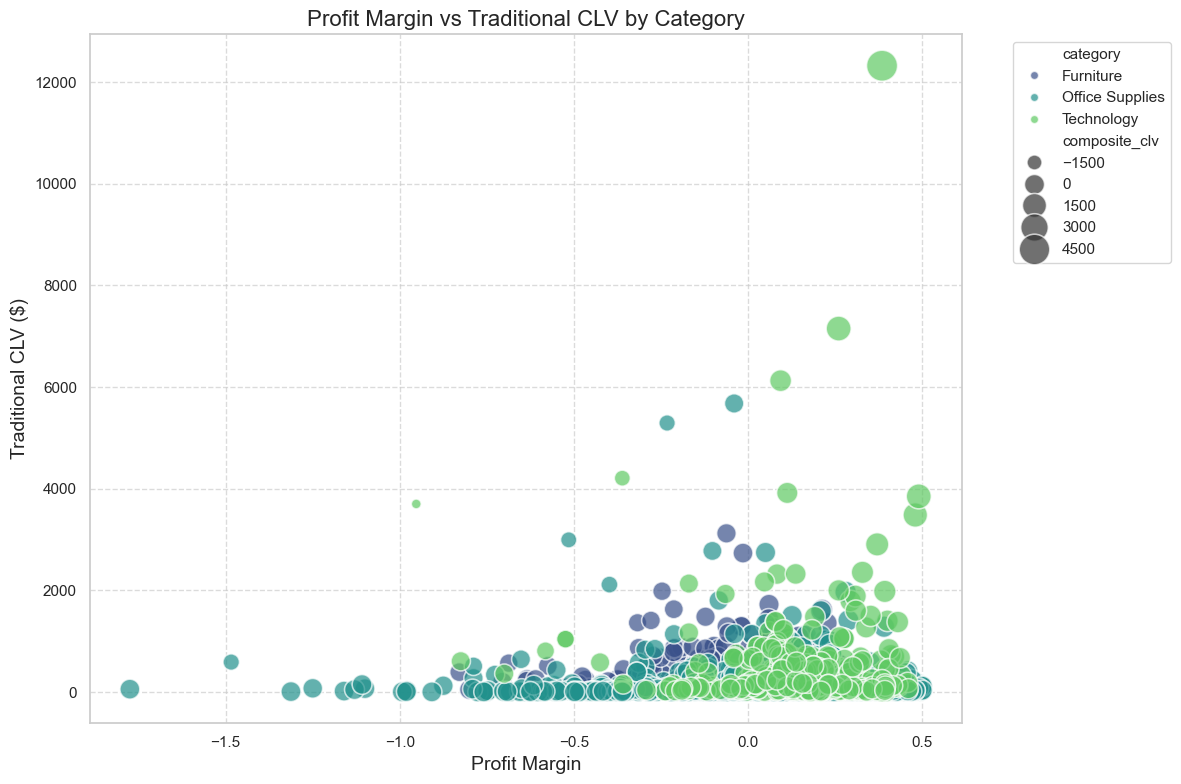

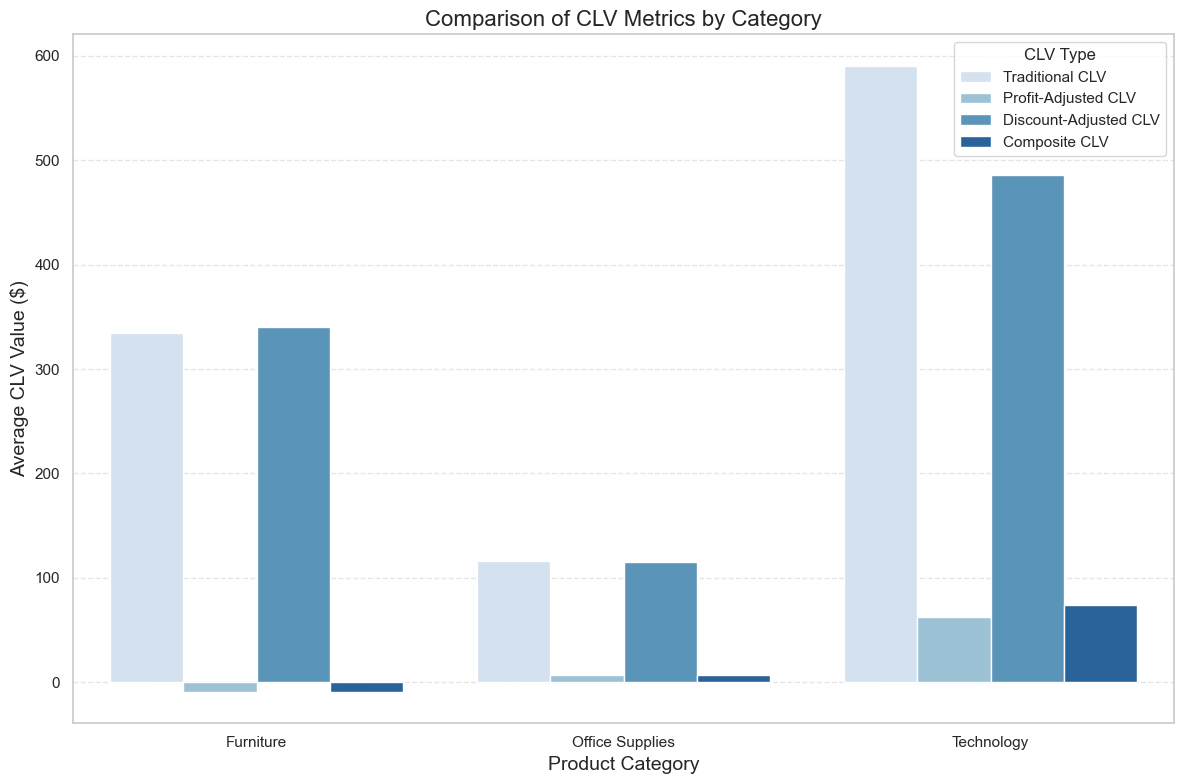

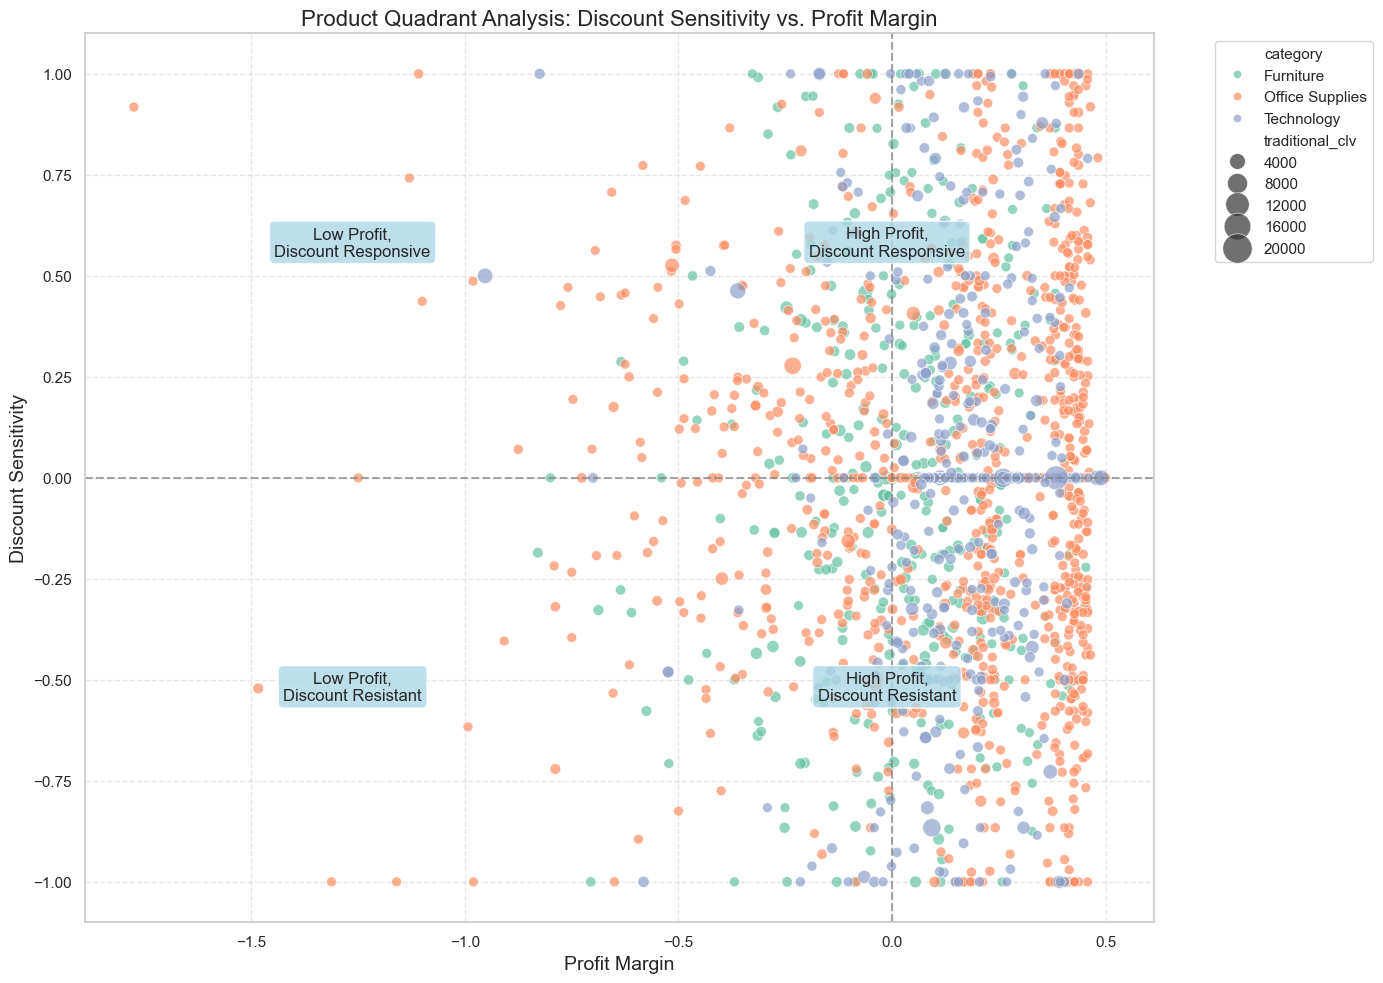

/var/folders/ms/kffv8scn23l62n_5h2kgw9sw0000gn/T/ipykernel_1220/976412489.py:187: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  top10_plot = sns.barplot(


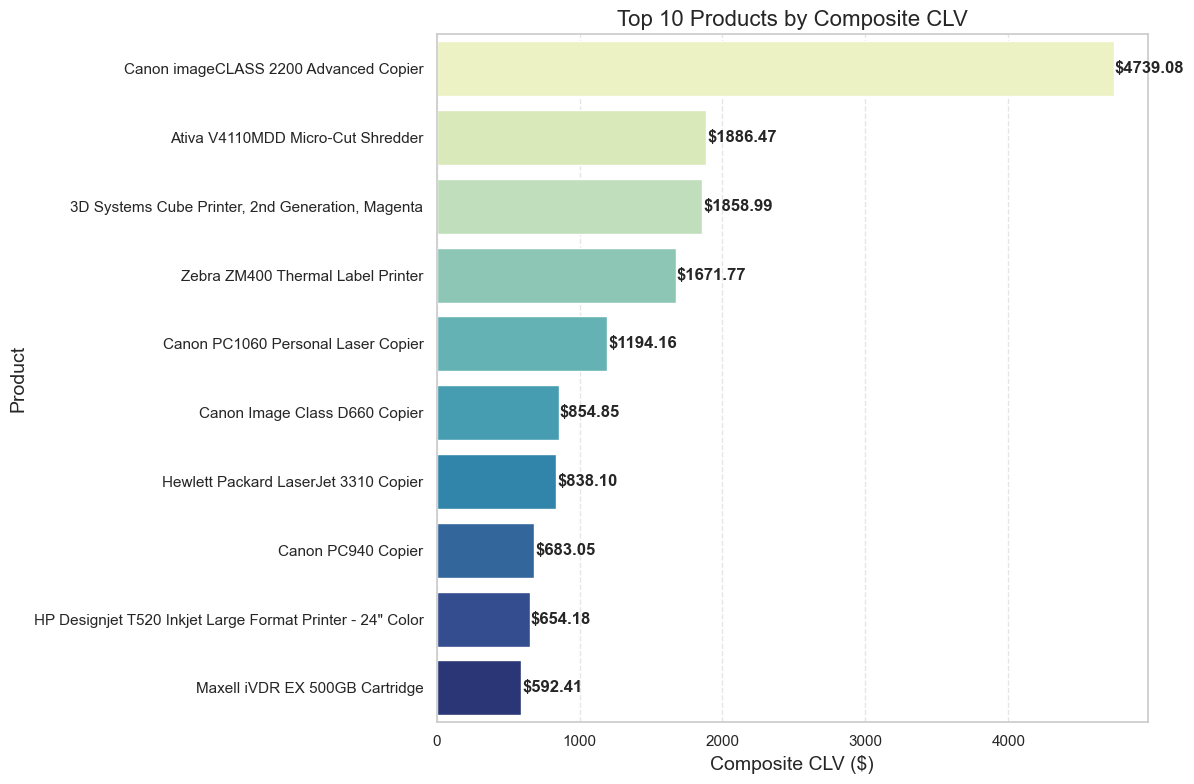

/var/folders/ms/kffv8scn23l62n_5h2kgw9sw0000gn/T/ipykernel_1220/976412489.py:221: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title='Category')


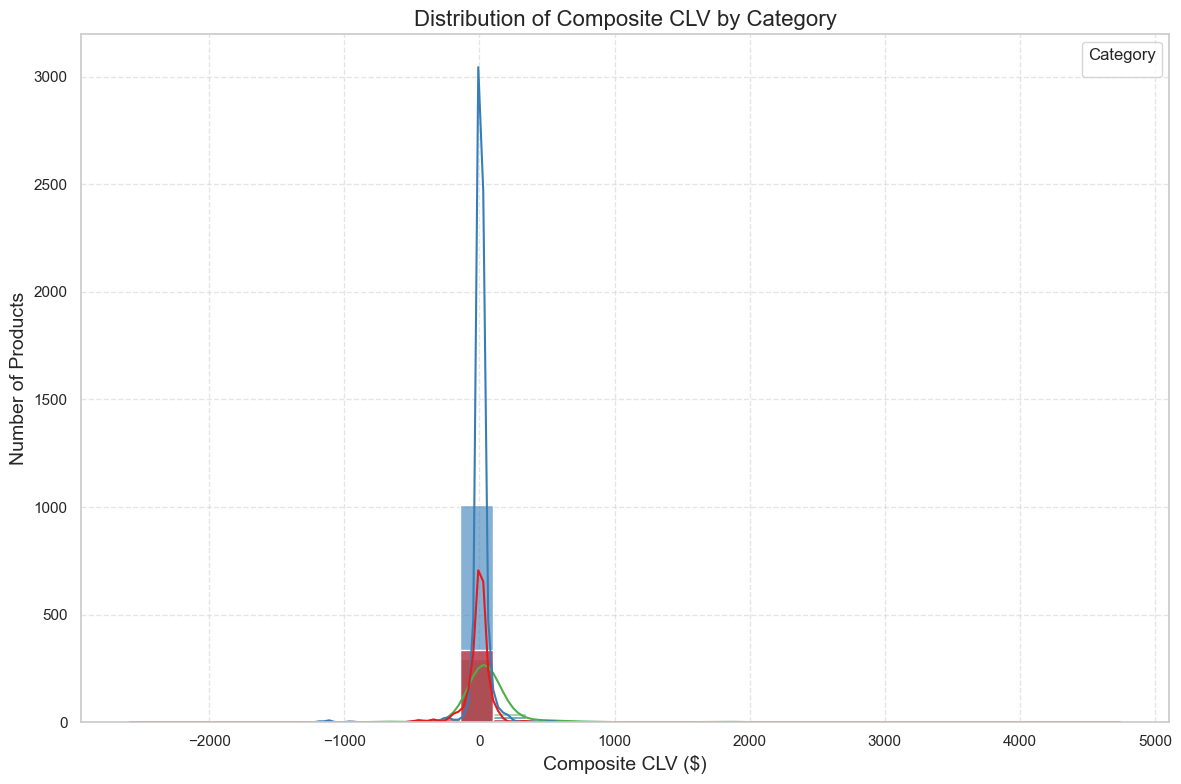

In [43]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set the seaborn style for better Jupyter display
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12

# Assuming 'ecom' DataFrame is already loaded and preprocessed with columns renamed
# If not, uncomment these lines:
ecom = pd.read_csv('superstore.csv', encoding='latin-1')

ecom.columns = ecom.columns.str.lower().str.replace(' ', '_', regex=True)
ecom['order_date'] = pd.to_datetime(ecom['order_date'])
ecom['ship_date'] = pd.to_datetime(ecom['ship_date'])

# Calculate metrics needed for CLV analysis
# Step 1: Calculate profit margin and organize data by product & customer
ecom['profit_margin'] = ecom['profit'] / ecom['sales']

# Group by product and customer
product_customer = ecom.groupby(['product_id', 'customer_id']).agg({
    'sales': 'sum',
    'profit': 'sum',
    'order_id': 'nunique',
    'order_date': 'max'
}).reset_index()

product_customer['profit_margin'] = product_customer['profit'] / product_customer['sales']

# Step 2: Calculate product-level metrics
product_clv = product_customer.groupby('product_id').agg({
    'sales': 'mean',
    'profit_margin': 'mean',
    'order_id': 'mean',
    'customer_id': 'nunique'
}).reset_index()

product_clv['traditional_clv'] = product_clv['sales'] * product_clv['order_id']
product_clv['profit_adjusted_clv'] = product_clv['traditional_clv'] * product_clv['profit_margin']

# Step 3: Calculate discount sensitivity
discount_sensitivity = []
for product in ecom['product_id'].unique():
    product_data = ecom[ecom['product_id'] == product]
    if product_data.shape[0] > 1:
        correlation = product_data['discount'].corr(product_data['quantity'])
        discount_sensitivity.append({
            'product_id': product,
            'discount_sensitivity': correlation if not np.isnan(correlation) else 0
        })

discount_df = pd.DataFrame(discount_sensitivity)
avg_discount = ecom.groupby('product_id')['discount'].mean().reset_index()
avg_discount.rename(columns={'discount': 'avg_discount'}, inplace=True)

# Step 4: Combine all metrics
discount_data = pd.merge(discount_df, avg_discount, on='product_id', how='left')
discount_clv = pd.merge(discount_data, 
                        product_clv[['product_id', 'traditional_clv']], 
                        on='product_id', how='left')
discount_clv['discount_adjusted_clv'] = discount_clv['traditional_clv'] * \
                                       (1 - (discount_clv['discount_sensitivity'] * discount_clv['avg_discount']))

# Combine all data
combined_clv = pd.merge(
    product_clv[['product_id', 'traditional_clv', 'profit_adjusted_clv', 'profit_margin']], 
    discount_clv[['product_id', 'discount_adjusted_clv', 'discount_sensitivity', 'avg_discount']],
    on='product_id', how='left'
)

# Add product info
product_info = ecom[['product_id', 'product_name', 'category', 'sub-category']].drop_duplicates()
combined_clv = pd.merge(combined_clv, product_info, on='product_id', how='left')
combined_clv['composite_clv'] = combined_clv['profit_adjusted_clv'] * \
                              (1 - (combined_clv['discount_sensitivity'] * combined_clv['avg_discount']))

# Create visualizations

# 1. Profit Margin vs CLV by Category (with improved styling for Jupyter)
plt.figure(figsize=(12, 8))
scatter = sns.scatterplot(
    x='profit_margin', 
    y='traditional_clv',
    hue='category',
    size='composite_clv',
    sizes=(50, 500),
    alpha=0.7,
    palette='viridis',
    data=combined_clv
)

# Format for better Jupyter display
scatter.set_title('Profit Margin vs Traditional CLV by Category', fontsize=16)
scatter.set_xlabel('Profit Margin', fontsize=14)
scatter.set_ylabel('Traditional CLV ($)', fontsize=14)
scatter.grid(True, linestyle='--', alpha=0.7)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()  # Explicitly show the plot in Jupyter

# 2. Category Comparison - Bar Plot with confidence intervals
plt.figure(figsize=(12, 8))
category_clv = combined_clv.groupby('category').agg({
    'traditional_clv': 'mean',
    'profit_adjusted_clv': 'mean',
    'discount_adjusted_clv': 'mean',
    'composite_clv': 'mean'
}).reset_index()

category_melted = pd.melt(
    category_clv, 
    id_vars=['category'],
    value_vars=['traditional_clv', 'profit_adjusted_clv', 'discount_adjusted_clv', 'composite_clv'],
    var_name='clv_type', 
    value_name='value'
)

# Map variable names to more readable labels
category_melted['clv_type'] = category_melted['clv_type'].map({
    'traditional_clv': 'Traditional CLV',
    'profit_adjusted_clv': 'Profit-Adjusted CLV',
    'discount_adjusted_clv': 'Discount-Adjusted CLV',
    'composite_clv': 'Composite CLV'
})

bar = sns.barplot(
    x='category', 
    y='value', 
    hue='clv_type', 
    data=category_melted,
    palette='Blues'
)

bar.set_title('Comparison of CLV Metrics by Category', fontsize=16)
bar.set_xlabel('Product Category', fontsize=14)
bar.set_ylabel('Average CLV Value ($)', fontsize=14)
bar.tick_params(axis='x', rotation=0)
plt.legend(title='CLV Type')
plt.grid(True, linestyle='--', alpha=0.5, axis='y')
plt.tight_layout()
plt.show()

# 3. Quadrant Analysis - Discount Sensitivity vs. Profit Margin
plt.figure(figsize=(14, 10))
quadrant = sns.scatterplot(
    x='profit_margin',
    y='discount_sensitivity',
    hue='category',
    size='traditional_clv',
    sizes=(50, 500),
    alpha=0.7,
    palette='Set2',
    data=combined_clv
)

# Add quadrant lines
plt.axhline(y=0, color='gray', linestyle='--', alpha=0.7)
plt.axvline(x=0, color='gray', linestyle='--', alpha=0.7)

# Add quadrant labels with better styling
plt.annotate('High Profit,\nDiscount Responsive', xy=(0.75, 0.75), xycoords='axes fraction',
            bbox=dict(boxstyle="round,pad=0.3", fc='lightblue', alpha=0.8), ha='center', fontsize=12)
plt.annotate('Low Profit,\nDiscount Responsive', xy=(0.25, 0.75), xycoords='axes fraction',
            bbox=dict(boxstyle="round,pad=0.3", fc='lightblue', alpha=0.8), ha='center', fontsize=12)
plt.annotate('High Profit,\nDiscount Resistant', xy=(0.75, 0.25), xycoords='axes fraction',
            bbox=dict(boxstyle="round,pad=0.3", fc='lightblue', alpha=0.8), ha='center', fontsize=12)
plt.annotate('Low Profit,\nDiscount Resistant', xy=(0.25, 0.25), xycoords='axes fraction',
            bbox=dict(boxstyle="round,pad=0.3", fc='lightblue', alpha=0.8), ha='center', fontsize=12)

quadrant.set_title('Product Quadrant Analysis: Discount Sensitivity vs. Profit Margin', fontsize=16)
quadrant.set_xlabel('Profit Margin', fontsize=14)
quadrant.set_ylabel('Discount Sensitivity', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# 4. Top 10 Products by Composite CLV
top10 = combined_clv.sort_values('composite_clv', ascending=False).head(10)
plt.figure(figsize=(12, 8))

# Create horizontal bar chart with custom styling
top10_plot = sns.barplot(
    y='product_name',
    x='composite_clv',
    data=top10,
    palette='YlGnBu',
    orient='h'
)

# Add value labels to the end of each bar
for i, v in enumerate(top10['composite_clv']):
    top10_plot.text(v + 5, i, f'${v:.2f}', va='center', fontweight='bold')

top10_plot.set_title('Top 10 Products by Composite CLV', fontsize=16)
top10_plot.set_xlabel('Composite CLV ($)', fontsize=14)
top10_plot.set_ylabel('Product', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.5, axis='x')
plt.tight_layout()
plt.show()

# 5. Distribution of CLV Values with KDE
plt.figure(figsize=(12, 8))
dist = sns.histplot(
    data=combined_clv,
    x='composite_clv',
    hue='category',
    kde=True,
    bins=30,
    alpha=0.6,
    palette='Set1'
)

dist.set_title('Distribution of Composite CLV by Category', fontsize=16)
dist.set_xlabel('Composite CLV ($)', fontsize=14)
dist.set_ylabel('Number of Products', fontsize=14)
plt.legend(title='Category')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

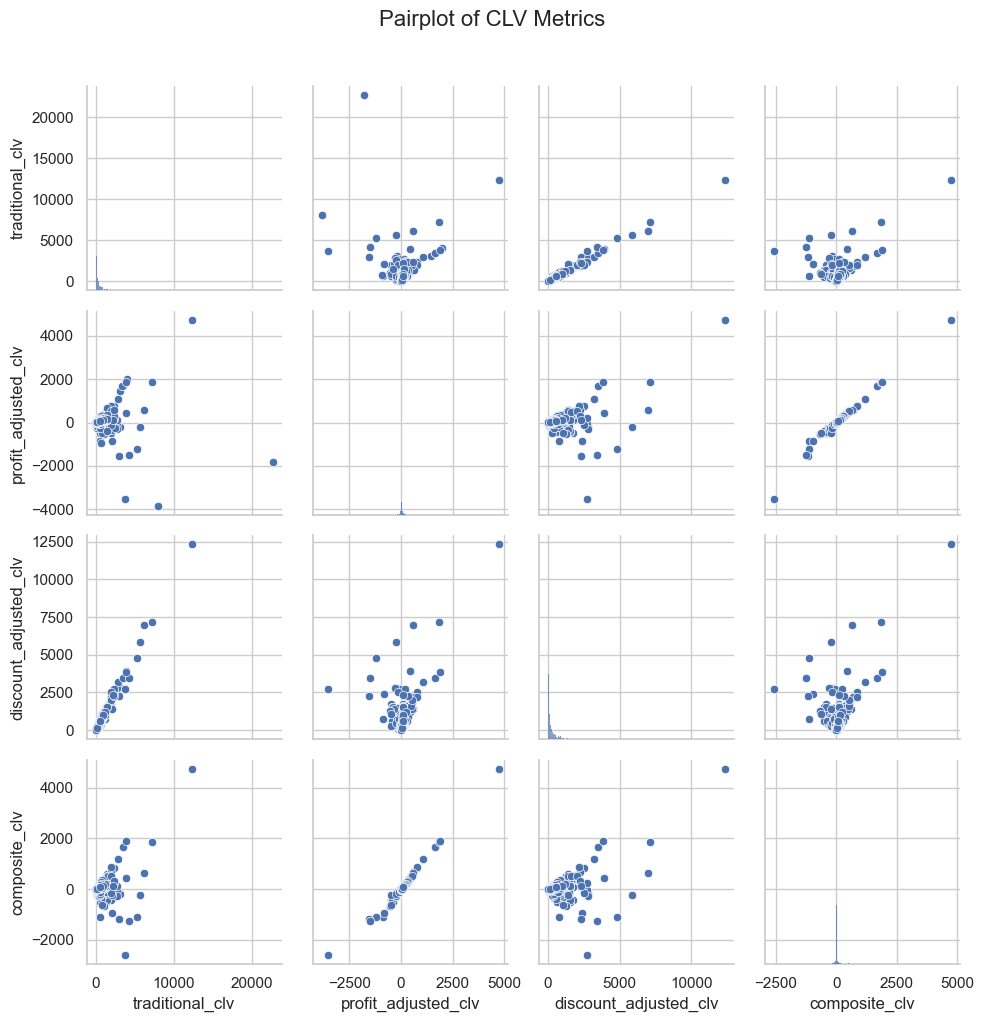

In [44]:
# 6. Pairplot of CLV Metrics
clv_metrics = combined_clv[['traditional_clv', 'profit_adjusted_clv', 'discount_adjusted_clv', 'composite_clv']]
sns.pairplot(clv_metrics, height=2.5)
plt.suptitle('Pairplot of CLV Metrics', y=1.02, fontsize=16)
plt.tight_layout()
plt.show()
